# Qwen2.5-Omni：通过屏幕录制实现智能信息交互
通过在录制屏幕上实时提问，使用Qwen2.5-Omni获取想了解的信息和内容。

# 环境准备

如果前面已经安装准备完成，跳过此章节

## 安装相关依赖
安装transformers、qwen-omni-utils、flash-attn --no-build-isolation

```bash
pip uninstall transformers
pip install git+https://github.com/huggingface/transformers@f742a644ca32e65758c3adb36225aef1731bd2a8
pip install accelerate
pip install triton
pip install qwen-omni-utils
pip install -U flash-attn --no-build-isolation
# 用于从魔塔模型库下载模型
pip install modelscope
```



## 模型下载准备

需要提前将模型下载到本地备用
使用 modelscope 中的 snapshot_download 函数下载模型（提前安装modelscope）。
第一个参数为模型名称，第二个参数 cache_dir 用于指定模型的下载路径.
```python

from modelscope import snapshot_download
model_dir = snapshot_download('Qwen/Qwen2.5-Omni-7B', cache_dir='/root/autodl-tmp', revision='master')

```

# 加载模型&导入依赖

加载本地下载的模型，同时启用flash_attention_2加速

In [2]:
import torch
from transformers import Qwen2_5OmniModel, Qwen2_5OmniProcessor
from IPython.display import Video

model_path = "/root/autodl-tmp/Qwen/Qwen2.5-Omni-7B"
model = Qwen2_5OmniModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
processor = Qwen2_5OmniProcessor.from_pretrained(model_path)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Qwen2_5OmniToken2WavModel must inference with fp32, but flash_attention_2 only supports fp16 and bf16, attention implementation of Qwen2_5OmniToken2WavModel will fallback to sdpa.


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

# 定义推理函数

推理函数，用于处理视频输入和文本提示，并生成文本输出。

In [3]:
from qwen_omni_utils import process_mm_info  # 导入处理多媒体信息的工具函数

# @title inference function
def inference(video_path, prompt, sys_prompt):
    # 构建对话消息列表，包括系统提示和用户输入
    messages = [
        {"role": "system", "content": sys_prompt},  # 系统角色消息
        {"role": "user", "content": [  # 用户角色消息
                {"type": "text", "text": prompt},  # 文本类型消息
                {"type": "video", "video": video_path},  # 视频类型消息
            ]
        },
    ]

    # 使用处理器将消息列表转换为模型输入文本，不进行分词，添加生成提示
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # 处理视觉信息，获取音频、图像和视频数据
    # image_inputs, video_inputs = process_vision_info([messages])
    audios, images, videos = process_mm_info(messages, use_audio_in_video=False)

    # 将文本和多媒体数据转换为模型输入张量，指定返回PyTorch张量，进行填充，不使用视频中的音频
    inputs = processor(text=text, audios=audios, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=False)

    # 将输入数据移动到模型设备上，并转换为模型数据类型
    inputs = inputs.to(model.device).to(model.dtype)

    # 使用模型生成输出，不使用视频中的音频，不返回音频
    output = model.generate(**inputs, use_audio_in_video=False, return_audio=False)

    # 使用处理器批量解码模型输出，跳过特殊标记，不清理分词空格
    text = processor.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    # 返回生成的文本
    return text


# 视频理解

In [4]:
# video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/screen.mp4"
video_path = "files/screen.mp4"
prompt = "What the browser is used in this video?"

display(Video(video_path, width=640, height=360))

## 调用模型进行推理（通过system提示，指定模型角色）.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

qwen-vl-utils using torchvision to read video.
/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:605: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv3d(


system
You are a helpful assistant.
user
What the browser is used in this video?
assistant
The browser used in the video is Google Chrome.


# OCR识别

In [5]:
# video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/screen.mp4"
video_path = "files/screen.mp4"
prompt = "Who is the authors of this paper?"

display(Video(video_path, width=640, height=360))

## 调用模型进行推理（通过system提示，指定模型角色）.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

system
You are a helpful assistant.
user
Who is the authors of this paper?
assistant
The authors of the paper "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Lukasz Kaiser
8. Illia Polosukhin


# 总结提炼

In [6]:
#video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/screen.mp4"
video_path = "files/screen.mp4"
prompt = "Summarize this paper in short."

display(Video(video_path, width=640, height=360))

## 调用模型进行推理（通过system提示，指定模型角色）.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

system
You are a helpful assistant.
user
Summarize this paper in short.
assistant
The paper "Attention Is All You Need" introduces the Transformer model, a novel architecture for sequence-to-sequence tasks that relies entirely on self-attention mechanisms. The Transformer outperforms existing models in machine translation tasks, achieving state-of-the-art BLEU scores on WMT 2014 English-German and English-French translation tasks. The model is trained using a stack of identical layers, each containing self-attention mechanisms and position-wise feed-forward networks. The paper also discusses the application of the Transformer to other tasks, such as English constituency parsing, and highlights its advantages over traditional recurrent neural network architectures.


# AI助手（理解+翻译）

In [ ]:
# video_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen2.5-Omni/screen.mp4"
video_path = "files/screen.mp4"
prompt = "Please trranslate the abstract of paper into Chinese."

display(Video(video_path, width=640, height=360))

## 调用模型进行推理（通过system提示，指定模型角色）.
response = inference(video_path, prompt=prompt, sys_prompt="You are a helpful assistant.")
print(response[0])

这一步推理效果不是很好，非常缓慢。。。。。

GPU资源消耗如下：
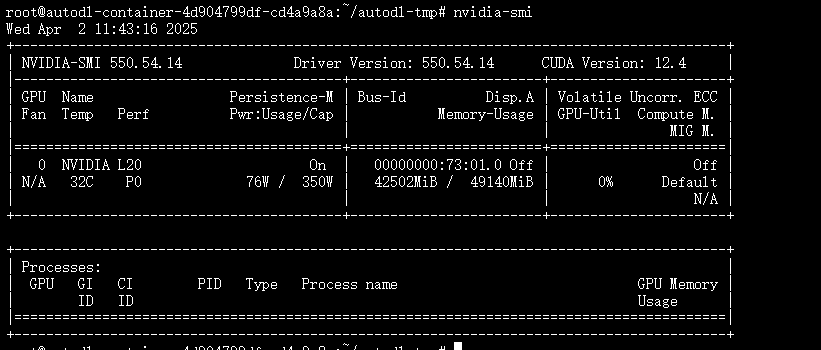